In [26]:
# Loading necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from src.utils.circularity import get_corres_circularity

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [27]:
# Initializing Pillow
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        "nearest": pil_image.NEAREST,
        "bilinear": pil_image.BILINEAR,
        "bicubic": pil_image.BICUBIC,
        "hamming": pil_image.HAMMING,
        "box": pil_image.BOX,
        "lanczos": pil_image.LANCZOS,
    }

In [28]:
# Initializing data directory
data_dir = Path("<main data directory containing subdirectories train/validation/test>")
data_folders = list(data_dir.iterdir())

print(data_folders)

[PosixPath('../../../ds1_multiclass/.DS_Store'), PosixPath('../../../ds1_multiclass/test'), PosixPath('../../../ds1_multiclass/train'), PosixPath('../../../ds1_multiclass/validation')]


In [29]:
# Aggregating all the labels for the different data splits
labels_df = pd.DataFrame()

for f in data_folders:
    if not str(f.stem).startswith('.'):
        split = f.parts[4]
        files = list(f.glob('*.csv'))
        print(files)
        temp_df = pd.read_csv(files[0], header=0, index_col=False)
        temp_df['split'] = split
        labels_df = pd.concat([labels_df,temp_df], axis=0)

print(labels_df.shape)

[PosixPath('../../../ds1_multiclass/test/labels.csv')]
[PosixPath('../../../ds1_multiclass/train/labels.csv')]
[PosixPath('../../../ds1_multiclass/validation/labels.csv')]
(7236, 6)


In [30]:
#Extracting the objects from these images and normalizing to standard size
labels_df[['img']].value_counts()

img          
6189 Z 150921    439
6189 J 051021    395
7518 G 210721    265
8530 Z 161121    263
7518 I 230621    253
                ... 
8219 A 021121      1
6569 A 210421      1
8225 K 070921      1
6427 C 280921      1
7626 F 040821      1
Length: 295, dtype: int64

In [31]:
# Calculating features by scaling to total feature length of 256

feature_arr = np.empty([len(labels_df),256])
feature_images = np.empty([len(labels_df),16,16])


for index, row in labels_df.iterrows():
    img = np.asarray(pil_image.open('../../../ds1/'+row['split']+
                                    '/img/cls/'+row['img']+'.tif').convert('L')).astype('uint8')
    mask  = np.asarray(pil_image.open('../../../ds1/'+row['split']+
                                    '/man_mask/cls/'+row['img']+'_Simple Segmentation.tif').convert('L')).astype('uint8')

    img = img*mask
    radius = int(np.ceil(np.sqrt(row['area']/np.pi)))

    clip_len = int(np.ceil(1.5*radius)) + 5
    img_height, img_width = img.shape

    #We assume that centroid-0 is y and centroid-1 is x

    img_clipped = img[max(int(row['y']-clip_len), 0): min(int(row['y']+clip_len), img_height),
        max(int(row['x']-clip_len), 0): min(int(row['x']+clip_len), img_width)]

    if np.any(img_clipped != 0):
        if img_clipped.shape[0]*img_clipped.shape[1] > 256 :
            im = pil_image.fromarray(img_clipped)

            ratio =256/(img_clipped.shape[0]*img_clipped.shape[1])
            
            if ratio == 0.0:
                pass  
            elif ratio == 1.0:
                pass
            else:
                img_clipped = np.array(im.resize((int(img_clipped.shape[1]*np.sqrt(ratio)), 
                                                int(img_clipped.shape[0]*np.sqrt(ratio))), 
                                                pil_image.BILINEAR))
                 
        if img_clipped.shape[0]*img_clipped.shape[1] >= 256 :
            feature = img_clipped.flatten()[:256]
        else:
            pad = (256 - len(img_clipped.flatten()))/2
            if pad != np.round(pad):
                feature = np.pad(img_clipped.flatten(), (int(np.floor(pad)), int(np.floor(pad))+1), 
                                'constant')
            else:
                feature = np.pad(img_clipped.flatten(),(int(pad),int(pad)),'constant')

        feature_images[index] = np.array(im.resize((16,16),pil_image.BILINEAR))
        feature_arr[index] = feature
    else:
        continue

In [32]:
# Removing cases of empty features
print(feature_arr.shape)
labels_df_nonempty = labels_df.iloc[~np.all(feature_arr == 0, axis=1)]

labels = np.array([int(x[6]) for x in labels_df['label']])
labels_for_visualization = np.array([x for x in labels_df['label']])

condition = ~np.all(feature_arr == 0, axis=1)

labels = np.extract(condition, labels)
labels_for_visualization = np.extract(condition,labels_for_visualization)

print(len(labels))
print(len(labels_for_visualization))

(7236, 256)
3562
3562


In [33]:
#Morphological feature clusters
multiclass_df_train = labels_df_nonempty[labels_df_nonempty['split']=='train']
multiclass_df_test = labels_df_nonempty[labels_df_nonempty['split']=='test']
multiclass_df_validation = labels_df_nonempty[labels_df_nonempty['split']=='validation']

multiclass_df_train= get_corres_circularity(multiclass_df_train,split='train')
multiclass_df_val= get_corres_circularity(multiclass_df_validation,split='validation')
multiclass_df_test= get_corres_circularity(multiclass_df_test,split='test')

In [34]:
df_list = [multiclass_df_train,multiclass_df_val,multiclass_df_test]

manually_labelled_df = pd.DataFrame()
for df in df_list:
    manually_labelled_df = pd.concat([manually_labelled_df,df])

print(manually_labelled_df.shape)

(3562, 6)


In [35]:
manually_labelled_df.head()

,label,x,y,img,area,circularity
0,class 2: RBC/WBC,131.584158,4.935644,130 G 261021,202,0.555988
1,class 2: RBC/WBC,401.429000,47.877000,130 G 261021,281,0.665112
2,class 2: RBC/WBC,40.965000,57.303000,130 G 261021,340,0.682445
3,class 2: RBC/WBC,89.986000,77.050000,130 G 261021,282,0.682039
4,class 2: RBC/WBC,288.263000,87.531000,130 G 261021,131,0.611218


In [36]:
manually_labelled_df['label'].value_counts()

class 1: rod            1697
class 2: RBC/WBC        1056
class 4: misc            550
class 5: single EPC      182
class 3: yeast            41
class 6: few EPC          26
class 7: several EPC      10
Name: label, dtype: int64

In [37]:
# Extracting only relevant columns
acdata = manually_labelled_df.drop(manually_labelled_df.columns[[0,1,2,3]], axis=1)
acdata

,area,circularity
0,202,0.555988
1,281,0.665112
2,340,0.682445
3,282,0.682039
4,131,0.611218
...,...,...
261,34,0.333945
262,28,0.258506
0,929,0.441864
1,40,0.329241


In [38]:
# Scaling the data
scaler = StandardScaler()

scaled_acdata = scaler.fit_transform(acdata)  
scaled_acdata

array([[-0.1219185 ,  0.78681196],
       [-0.10750153,  1.28042695],
       [-0.09673442,  1.35883206],
       ...,
       [ 0.01075414,  0.27057685],
       [-0.15148242, -0.2388667 ],
       [-0.12903574,  0.98879736]])

Text(0, 0.5, 'circularity')

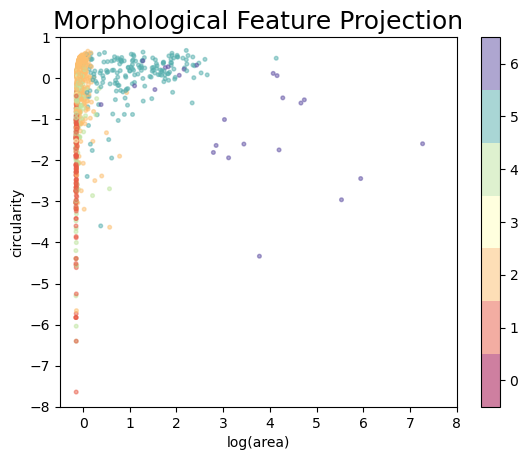

In [39]:
plt.scatter(scaled_acdata[:,0], np.log(scaled_acdata[:,1]), c=np.array([int(x[6]) for x in manually_labelled_df['label']]), cmap='Spectral', s=7, vmin=0, vmax =6, alpha =0.5)
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(7))
plt.xlim(-0.5,8)
plt.ylim(-8,1)

plt.title('Morphological Feature Projection', fontsize=18)
plt.xlabel('log(area)')
plt.ylabel('circularity')
# plt.savefig(f'<filepath/filename>.svg')